## Cellpose Pipeline - Cell Size & Foci Analysis

In [56]:
""" might need to run:
    conda create -n cellpose_env python=3.10
    conda activate cellpose_env

    conda install -c conda-forge numpy scipy matplotlib pandas scikit-image
    pip install cellpose==3.1.1.2 (cellpose is maintained in PyPI)
"""

' might need to run:\n    conda create -n cellpose_env python=3.10\n    conda activate cellpose_env\n\n    conda install -c conda-forge numpy scipy matplotlib pandas scikit-image\n    pip install cellpose==3.1.1.2 (cellpose is maintained in PyPI)\n'

In [57]:
""" Imports and Functions """
import numpy as np # array (img) analysis
import pandas as pd # working with dtaframes
from cellpose import models # segmentation + DL
from scipy.stats import pearsonr # statistics for relationship (custom)
import seaborn as sns # visualization/plots
import matplotlib.pyplot as plt #  viasualization/plots
from skimage import io, measure, morphology, filters # io -> read image | measure -> extract features | morphology -> clean masks | filters -> threshold and smooth
from scipy import ndimage as ndi# Laplacian of Gaussian (LoG) to detect foci 

In [58]:
# open and read image
image = io.imread("/Users/camic.a/Desktop/C1-MAX_50ms50G_20P_6h_185.tif")

# visualize img to array conversion (& dimensions/channels)
print("image shape: \n", image.shape)
print("dimensions of image: \n", image.ndim)
print("before selection of channel: \n", image , "\n\n\n")


""" WHEN IMAGES HAVE MORE THAN ONE CHANNEL:

    # Ensure we pick a single channel
    if image.ndim == 3:
    # take the first channel (if grayscale) -----need to double check with images-----
    image = image[:, :, 0]
"""

image = image.astype(np.float32) # intensities as float 32 (better precision)

# visualize what is taken to analyze
print("image shape: \n", image.shape)
print("after selection of channel: \n", image)

image shape: 
 (512, 512)
dimensions of image: 
 2
before selection of channel: 
 [[107 107 107 ... 108 110 110]
 [106 107 105 ... 111 107 110]
 [105 108 107 ... 110 108 109]
 ...
 [107 109 108 ... 105 106 108]
 [109 106 107 ... 108 105 105]
 [106 107 108 ... 107 104 105]] 



image shape: 
 (512, 512)
after selection of channel: 
 [[107. 107. 107. ... 108. 110. 110.]
 [106. 107. 105. ... 111. 107. 110.]
 [105. 108. 107. ... 110. 108. 109.]
 ...
 [107. 109. 108. ... 105. 106. 108.]
 [109. 106. 107. ... 108. 105. 105.]
 [106. 107. 108. ... 107. 104. 105.]]


In [70]:
# cell segmentation with cellpose
model = models.Cellpose(model_type='cyto') # There are two types in this version -> cyto & nuclei

# normalize & running NN ----- need to double check out & in correlation -----
masks, flows, styles, diams = model.eval(
    image,
    channels=[0, 0]
)

In [78]:
# Visualize & understand what happens with the values
print("Image shape:", image.shape) 
print("Masks shape:", masks.shape, "\n\n")
print("Image ndim:", image.ndim)
print("Masks ndim:", masks.ndim)
print("masks: ", masks, "\n\n")

print("flow: ", flows, "\n\n")
print("styles: ", styles, "\n\n")

Image shape: (512, 512)
Masks shape: (512, 512) 


Image ndim: 2
Masks ndim: 2
masks:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 


flow:  [array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  5,  7],
        [ 0,  5,  9],
        [ 0,  3,  4]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  6, 10],
        [ 0,  5,  8],
        [ 0,  3,  5]],

       [[ 1,  0,  0],
        [ 1,  1,  0],
        [ 1,  0,  0],
        ...,
        [ 0,  3,  8],
        [ 0,  2,  4],
        [ 0,  1,  2]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 1,  1,  0],
        [ 1,  1,  0],
        ...,
        [ 1,  1,  0],
        [ 1,  1,  0],
        [ 1,  0,  0]],

       [[ 0,  0,  0],
        [ 1,

In [62]:
# extract features from the segmented cells
cell_props = measure.regionprops(masks, intensity_image=image)

cell_data = []

for prop in cell_props:
    cell_data.append({
        "cell_id": prop.label, # the region 
        "area": prop.area, # number of pixels in the cell detected
        "major_axis_length": prop.major_axis_length, # long axis 
        "minor_axis_length": prop.minor_axis_length, # short axis
        "eccentricity": prop.eccentricity, # shape of cell (binary output -> 0: circle, 1: line)
        "mean_intensity": prop.mean_intensity # mean intensity of the cell
    })

# add all info to DF to visualize 
cell_df = pd.DataFrame(cell_data)

In [63]:
# detecting the foci inside of the green channel

# Smooth image
smoothed = filters.gaussian(image, sigma=1)

# Enhance puncta
log_image = -ndi.gaussian_laplace(smoothed, sigma=1)

# Normalize
log_image = (log_image - log_image.min()) / (log_image.max() - log_image.min())

# Threshold
threshold = filters.threshold_otsu(log_image)
foci_mask = log_image > threshold

# Remove tiny noise
foci_mask = morphology.remove_small_objects(foci_mask, min_size=5)

In [64]:
# label the foci
foci_labels = measure.label(foci_mask)

In [65]:
# relate foci to cells
foci_props = measure.regionprops(foci_labels, intensity_image=image)

# Initialize foci metrics per cell
cell_df["foci_count"] = 0
cell_df["foci_total_area"] = 0
cell_df["foci_total_intensity"] = 0

for foci in foci_props:
    coords = foci.coords
    cell_labels = masks[coords[:,0], coords[:,1]]
    
    # Find dominant cell label
    cell_label = np.bincount(cell_labels).argmax()
    
    if cell_label == 0:
        continue
    
    idx = cell_df.index[cell_df["cell_id"] == cell_label][0]
    
    cell_df.loc[idx, "foci_count"] += 1
    cell_df.loc[idx, "foci_total_area"] += foci.area
    cell_df.loc[idx, "foci_total_intensity"] += foci.mean_intensity * foci.area

/var/folders/qw/jg34zg4s36s3q9b0cy00dw4m0000gn/T/ipykernel_86505/2008000846.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3495.9999389648438' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cell_df.loc[idx, "foci_total_intensity"] += foci.mean_intensity * foci.area


In [66]:
# normalize the foci
cell_df["foci_per_area"] = cell_df["foci_count"] / cell_df["area"]
cell_df["foci_area_fraction"] = cell_df["foci_total_area"] / cell_df["area"]

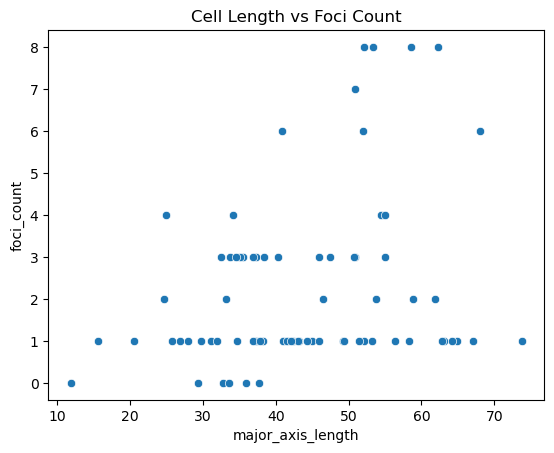

In [67]:
# Visualize the relationship between cell size and foci count
plt.figure()
sns.scatterplot(
    data=cell_df,
    x="major_axis_length",
    y="foci_count"
)
plt.title("Cell Length vs Foci Count")
plt.show()

In [68]:
# correlation calculation
r, p = pearsonr(cell_df["major_axis_length"], cell_df["foci_count"])
print("Pearson r:", r)
print("p-value:", p)

Pearson r: 0.288690276962149
p-value: 0.013249825614598367
